# Garbage Classification with Machine Learning
**Course:** Data Mining and Machine Learning - **Term:** Fall 2024  
**Instructor:** Dr. Roberto Souza 
 
**Student:** Ali Mohammadi Ruzbahani

---

### Overview
This project is the second assignment for the Data Mining and Machine Learning course in Fall 2024. The goal is to develop a machine learning model for **classifying garbage images** based on the waste management system of Calgary, Alberta. The model leverages both image data and textual descriptions associated with each image to improve classification accuracy.

### Project Stages
1. **Data Collection and Preprocessing**  
2. **Design and Development of a Combined Image and Text Processing Model**  
3. **Training and Optimization**  
4. **Evaluation and Analysis of Results**

### Applications
This project can contribute to **smart waste management systems**, **automatic recycling**, and **waste type detection** in smart devices. The model moves toward optimizing waste management and enhancing recycling processes through deep learning.

---

> **Note:** This Jupyter Notebook contains the code and explanations for all project stages, from data preparation to model training and evaluation.

# Importing Essential Libraries

In [2]:
import os 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet18_Weights
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch.nn.init as init
from tqdm import tqdm

# Define the device for computation
**The code snippet sets up PyTorch to use a GPU if available, otherwise it defaults to the CPU, and prints out the device being used.**

In [3]:
# Setting up the device for computation (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'I will use {device}')

I will use cuda


# Step 1: Define the Custom Dataset
**A custom dataset class for classifying garbage images, where it loads image data along with their labels and text descriptions from filenames, applying specified transformations.**

In [4]:
# Define the Custom Dataset for garbage image classification
# The dataset includes images, labels, and descriptions
class GarbageDataset(Dataset):
    def __init__(self, folder_path, transform=None, vocab=None, max_description_len=5):
        self.folder_path = folder_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.descriptions = []
        self.max_description_len = max_description_len
        self.vocab = vocab or {}
        
        label_dict = {'Black': 0, 'Green': 1, 'Blue': 2, 'TTR': 3}
        
        for label_name, label_idx in label_dict.items():
            label_folder = os.path.join(folder_path, label_name)
            if not os.path.isdir(label_folder):
                continue
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                self.data.append(img_path)
                self.labels.append(label_idx)
                
                # Extracting descriptions from the filename and padding to a fixed length
                description = filename.split('.')[0].split('_')
                description_indices = [self._word_to_idx(word) for word in description]
                
                if len(description_indices) < self.max_description_len:
                    description_indices += [0] * (self.max_description_len - len(description_indices))
                else:
                    description_indices = description_indices[:self.max_description_len]
                    
                self.descriptions.append(description_indices)

    def _word_to_idx(self, word):
        if word not in self.vocab:
            self.vocab[word] = len(self.vocab)
        return self.vocab[word]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        description_indices = self.descriptions[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(description_indices), torch.tensor(label)



# Dataset Directories

In [5]:
# Data path in the system for use in the program
#I have set the data paths to local directories on my hard drive. Please change the data paths to your desired directories before testing the code.
#The default dataset path : /work/TALC/enel645_2024f/garbage_data
base_path = 'C:/ali/garbage_data'  
train_folder = os.path.join(base_path, 'CVPR_2024_dataset_Train')
val_folder = os.path.join(base_path, 'CVPR_2024_dataset_Val')
test_folder = os.path.join(base_path, 'CVPR_2024_dataset_Test')


# Dataset and data configuration
### This cell configures the dataset and data loading settings:
1. **Training Transformations (torchvision_transform):** A combination of random resizing, cropping, flipping, rotation, and color adjustments to augment the training data for better generalization. It also includes normalization to scale image pixel values for better neural network performance.
**Testing/Validation Transformations:** (torchvision_transform_test): Simpler transformations involving only resizing and normalization, since test/validation data should not be augmented to reflect true performance metrics. 
2. **Dataset Loading:** Instantiates the GarbageDataset for training, validation, and testing using the respective transformations. The training dataset’s vocabulary is reused for the validation and test datasets to ensure consistency in text processing.
3. **Data DataLoaders:** train_loader: Batches and shuffles training data to ensure model robustness and prevent overfitting.
val_loader and test_loader: Batch but do not shuffle validation and test data to evaluate the model performance on a fixed set of data.
4. **Batch Size and Workers:** Sets the batch size to 64, which is a balance between memory usage and performance efficiency.
Configures the number of worker threads (num_workers) to 4 to parallelize data loading and improve training speed.

In [6]:
# Define a series of transformations to apply to the training images
torchvision_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

torchvision_transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoaders
train_dataset = GarbageDataset(train_folder, transform=torchvision_transform)
val_dataset = GarbageDataset(val_folder, transform=torchvision_transform_test, vocab=train_dataset.vocab)
test_dataset = GarbageDataset(test_folder, transform=torchvision_transform_test, vocab=train_dataset.vocab)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define batch size and number of workers for data loading (adjust as needed for system performance)
batch_size = 64
num_workers = 4

# Displaying Augmented Training Images
**In this cell, we load a batch of training images with data augmentations applied and display a few examples.** 
**This helps in understanding how the augmentations affect the training data visually.**

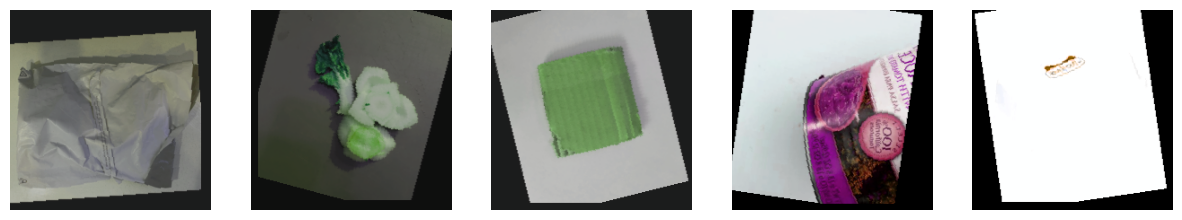

In [7]:
# Get a batch of images
data_iter = iter(train_loader)
images, descriptions, labels = next(data_iter)

# Display a few images with applied augmentations
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = images[i].numpy().transpose((1, 2, 0))
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Revert normalization
    img = np.clip(img, 0, 1)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

# Class Label Configuration for Garbage Classification:
1. **Class Name Definition:** Defines class names for garbage types such as 'Black', 'Green', 'Blue', and 'TTR' in the class_names list, matching folder names in the dataset.

2. **Mapping Classes to Indices:** Creates a dictionary class_to_idx that maps each class name to a unique integer, facilitating numerical processing in models.

3. **Reverse Mapping and Dataset Size Info:** Establishes a reverse dictionary idx_to_class for converting indices back to class names and prints the total number of images in each dataset part (training, validation, test) for verification.

In [6]:
# Define class names for each types of garbage (categories based on folder names)
class_names = ['Black', 'Green', 'Blue', 'TTR']

# Create a dictionary that maps each class name to a unique index (e.g., 'Black' -> 0, 'Green' -> 1, etc.)
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

# Create a reverse dictionary that maps each index back to the class name (e.g., 0 -> 'Black', 1 -> 'Green', etc.)
idx_to_class = {idx: class_name for idx, class_name in enumerate(class_names)}

# Print the list of class names to verify the setup
print(class_names)

# Calculate and print the total number of images in the training set
print("Train set:", len(train_loader) * batch_size)

# Calculate and print the total number of images in the validation set
print("Val set:", len(val_loader) * batch_size)

# Calculate and print the total number of images in the test set
print("Test set:", len(test_loader) * batch_size)

['Black', 'Green', 'Blue', 'TTR']
Train set: 10240
Val set: 1856
Test set: 3456


# Extracting Image Paths, Labels, and Text Descriptions from Dataset Folders
**This cell defines a function, extract_data_from_folders, which extracts image paths, labels, and text descriptions from a given folder structure. Each subfolder represents a class label and contains images related to that label.**

In [7]:
# Extract images, labels, and text descriptions from a given folder
def extract_data_from_folders(base_dir):
    data = []

    # Traverse through each subfolder
    for label_folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label_folder)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Loop through each image file in the subfolder
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):  # Filter image files
                    image_path = os.path.join(folder_path, filename)

                    # Extract text from filename (remove file extension)
                    text_description = os.path.splitext(filename)[0]

                    # Append image path, text, and label to the data list
                    data.append({
                        'image_path': image_path,
                        'text_description': text_description,
                        'label': label_folder  # The subfolder name represents the label (bin)
                    })

    # Convert to DataFrame for easy manipulation
    return pd.DataFrame(data)

# Extract the data
trainset_df = extract_data_from_folders(train_folder)
valset_df = extract_data_from_folders(val_folder)
testset_df = extract_data_from_folders(test_folder)


# Class Distribution in Training Dataset:

In [8]:
# Train Set
print (trainset_df['label'].value_counts())

label
Blue     4355
Black    2111
Green    1991
TTR      1743
Name: count, dtype: int64


# Class Distribution in Validation Dataset:

In [9]:
# Validation Set
print (valset_df['label'].value_counts())

label
Blue     768
Black    372
Green    352
TTR      308
Name: count, dtype: int64


# Class Distribution in Test Dataset:

In [10]:
# Test Set
print (testset_df['label'].value_counts())

label
Blue     1085
TTR       852
Green     799
Black     695
Name: count, dtype: int64


# Visualizing Class Distribution Across Training, Validation, and Test Datasets:
**This code block aggregates and visualizes the distribution of class labels across the training, validation, and test datasets using a bar chart. It provides a clear comparison of how many samples from each class are present in each dataset segment. By setting up a bar chart with side-by-side bars for each dataset, it helps identify any imbalances that could affect model training and generalization. Labels for the x-axis represent the class names, while the y-axis shows the count of samples per class, making it easy to see which classes are overrepresented or underrepresented in the datasets. This visualization is essential for assessing dataset quality and planning any necessary preprocessing steps to ensure a balanced training process**

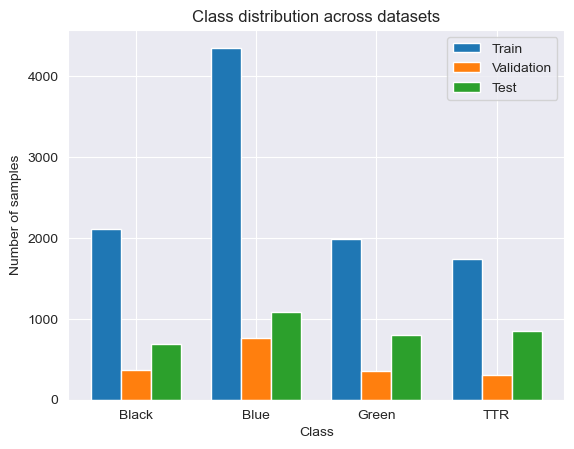

In [11]:
# Aggregate the count of labels from each dataset
train_counts = trainset_df['label'].value_counts().sort_index()
val_counts = valset_df['label'].value_counts().sort_index()
test_counts = testset_df['label'].value_counts().sort_index()

# Create a bar chart
fig, ax = plt.subplots()
index = range(len(train_counts))
bar_width = 0.25

ax.bar(index, train_counts, bar_width, label='Train')
ax.bar([p + bar_width for p in index], val_counts, bar_width, label='Validation')
ax.bar([p + bar_width * 2 for p in index], test_counts, bar_width, label='Test')

ax.set_xlabel('Class')
ax.set_ylabel('Number of samples')
ax.set_title('Class distribution across datasets')
ax.set_xticks([p + bar_width for p in index])
ax.set_xticklabels(train_counts.index)
ax.legend()

plt.show()

# Inspecting Batch Sizes from the Training DataLoader

In [12]:
train_iterator = iter(train_loader)
train_batch = next(train_iterator)
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([64, 3, 224, 224])
torch.Size([64, 5])


# Displaying an Image from the Training Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..1.7511113].


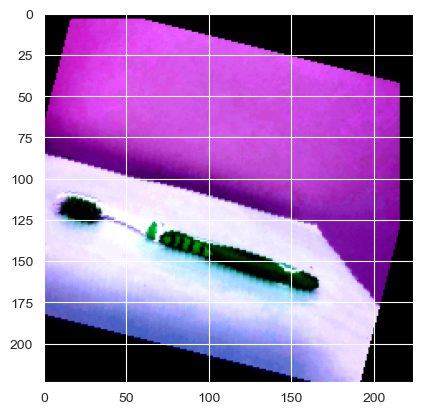

In [13]:
plt.figure()
plt.imshow(train_batch[0].numpy()[10].transpose(1,2,0))
plt.show()

# Weight Initialization Function for Neural Network Layers

In [14]:
# Define a function to initialize weights
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Using Xavier initialization for Linear layers
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        # Using Xavier initialization for LSTM weights
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)
            elif 'bias' in name:
                init.constant_(param.data, 0)

# CombinedModel for Multimodal Learning with Visualization Utilities
**The CombinedModel is a sophisticated neural network class defined using PyTorch, designed to process both visual and textual data simultaneously. It leverages a pretrained ResNet18 for extracting image features and incorporates a bidirectional LSTM (BiLSTM) with an attention mechanism for text processing. The class initialization involves setting up the ResNet18 where the final layer is adapted to match the hidden dimension size, and only the parameters of the last layer (layer4) are trainable. This is to fine-tune the high-level features for the specific task while keeping the lower-level feature extraction fixed.**

**For text, the model uses an embedding layer to convert vocab indices into dense vectors, followed by a BiLSTM that processes these vectors. The attention layer weighs the importance of each timestep’s output from the BiLSTM, allowing the model to focus on more relevant parts of the text data. The resulting text features and image features are then concatenated and passed through a dropout layer to prevent overfitting before being fed into a fully connected layer that classifies the combined features into one of the predefined categories.**

**The forward method outlines how data flows through the model during training or inference, processing both an image and its corresponding textual description to produce a final prediction. This model is particularly useful for applications where insights from both image and text are necessary, such as in automated tagging systems or multimedia content analysis.**

**Additionally, this script includes several plotting functions to visualize different aspects of the training process. These functions allow for the plotting of confusion matrices, training/validation loss curves, accuracy, and F1 score over epochs. These visual tools are essential for monitoring the model’s performance, diagnosing issues in training, and ensuring the model is learning as expected. They provide a clear, visual representation of the model's ability to generalize and its performance on both training and validation datasets, aiding in effective model tuning and validation.**

In [15]:
class CombinedModel(nn.Module):
    def __init__(self, vocab_sizes, embedding_dim=128, hidden_dim=266, num_classes=4, dropout_rate=0.6):
        super(CombinedModel, self).__init__()
        
        # Initialize the pretrained ResNet18 model for image processing
        self.image_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Replace the fully connected layer to match the hidden dimension
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, hidden_dim)
        # Freeze all parameters of the model to prevent them from being updated during training
        for param in self.image_model.parameters():
            param.requires_grad = False
        # Unfreeze the parameters of layer4 to allow training on them
        for param in self.image_model.layer4.parameters():
            param.requires_grad = True

        # Setup for text processing: embedding layer, BiLSTM, and Attention mechanism
        self.embedding = nn.Embedding(vocab_sizes, embedding_dim)  # Embedding layer for textual input
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)  # Bi-directional LSTM for capturing context
        self.text_fc = nn.Linear(hidden_dim * 2, hidden_dim)  # Linear layer to process LSTM output
        self.attention = nn.Linear(hidden_dim * 2, 1)  # Attention layer to compute importance weights
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer to prevent overfitting

        # Fully connected layer to combine features from image and text and classify them
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, image, description):
        # Extract features from the image using the pretrained ResNet18
        img_features = self.image_model(image)
        
        # Process the text description
        description = self.embedding(description)  # Convert text indices to embeddings
        lstm_out, _ = self.lstm(description)  # Pass embeddings through LSTM
        
        # Apply attention mechanism to the LSTM outputs
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        text_features = (lstm_out * attention_weights).sum(dim=1)  # Weighted sum of LSTM outputs
        
        # Process text features through a linear layer and apply dropout
        text_features = self.text_fc(text_features)
        text_features = self.dropout(text_features)

        # Concatenate image and text features and pass through a dropout layer
        combined_features = torch.cat((img_features, text_features), dim=1)
        combined_features = self.dropout(combined_features)
        
        # Output the final classification result
        output = self.fc(combined_features)
        return output


# Visualization functions for model training outcomes
def plot_confusion_matrix(conf_matrixs, class_namess):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrixs, annot=True, fmt="d", cmap="Blues", xticklabels=class_namess, yticklabels=class_namess)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    plt.show()

def plot_training_validation_loss(training_lossess, validation_lossess):
    plt.figure(figsize=(10, 6))
    plt.plot(training_lossess, label="Training Loss")
    plt.plot(validation_lossess, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.show()   

def plot_training_validation_accuracy(training_accuraciess, validation_accuraciess):
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuraciess, label="Training Accuracy")
    plt.plot(validation_accuraciess, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy Over Epochs")
    plt.legend()
    plt.show()    

def plot_training_validation_f1_score(training_f1_scoress, validation_f1_scoress):
    plt.figure(figsize=(10, 6))
    plt.plot(training_f1_scoress, label="Training F1 Score")
    plt.plot(validation_f1_scoress, label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Training and Validation F1 Score Over Epochs")
    plt.legend()
    plt.show()
    

# Model Reinitialization and Optimization Configuration

In [16]:
# Reinitialize model with new dropout rate
vocab_size = len(train_dataset.vocab)
model = CombinedModel(vocab_size).to(device)

# Update optimizer with increased weight decay
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0006)

# Define loss function (criterion) for classification
criterion = nn.CrossEntropyLoss()

# Add a learning rate scheduler to adjust the learning rate during training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.65)

# Implementing a Training Loop with Early Stopping for a Multimodal Model
**This script outlines the training process for a multimodal neural network model, featuring early stopping to prevent overfitting if no improvement in validation loss is observed over a specified number of epochs. It tracks and visualizes performance metrics such as loss, accuracy, and F1 scores for both training and validation. The model saves automatically when achieving the best validation loss and stops early if no improvement occurs after the set patience, optimizing computational efficiency and model performance.**

Epoch [1/15]


Validation: 100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


Epoch [1/15], Training Loss: 0.6588, Validation Loss: 0.5787, Training Accuracy: 0.7548, Validation Accuracy: 0.7867, Training F1 Score: 0.7521, Validation F1 Score: 0.7839
Epoch [2/15]


Validation: 100%|██████████| 29/29 [00:39<00:00,  1.38s/it]


Epoch [2/15], Training Loss: 0.5016, Validation Loss: 0.4839, Training Accuracy: 0.8205, Validation Accuracy: 0.8300, Training F1 Score: 0.8194, Validation F1 Score: 0.8288
Epoch [3/15]


Validation: 100%|██████████| 29/29 [00:39<00:00,  1.38s/it]


Epoch [3/15], Training Loss: 0.4178, Validation Loss: 0.4402, Training Accuracy: 0.8505, Validation Accuracy: 0.8467, Training F1 Score: 0.8498, Validation F1 Score: 0.8468
Epoch [4/15]


Validation: 100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


Epoch [4/15], Training Loss: 0.3309, Validation Loss: 0.4533, Training Accuracy: 0.8875, Validation Accuracy: 0.8467, Training F1 Score: 0.8871, Validation F1 Score: 0.8461
Early stopping trigger times: 1
Epoch [5/15]


Validation: 100%|██████████| 29/29 [00:40<00:00,  1.38s/it]


Epoch [5/15], Training Loss: 0.2914, Validation Loss: 0.4147, Training Accuracy: 0.9036, Validation Accuracy: 0.8478, Training F1 Score: 0.9033, Validation F1 Score: 0.8473
Epoch [6/15]


Validation: 100%|██████████| 29/29 [00:40<00:00,  1.39s/it]


Epoch [6/15], Training Loss: 0.2582, Validation Loss: 0.3857, Training Accuracy: 0.9160, Validation Accuracy: 0.8678, Training F1 Score: 0.9158, Validation F1 Score: 0.8669
Epoch [7/15]


Validation: 100%|██████████| 29/29 [00:40<00:00,  1.38s/it]


Epoch [7/15], Training Loss: 0.2080, Validation Loss: 0.3915, Training Accuracy: 0.9358, Validation Accuracy: 0.8628, Training F1 Score: 0.9357, Validation F1 Score: 0.8622
Early stopping trigger times: 1
Epoch [8/15]


Validation: 100%|██████████| 29/29 [00:40<00:00,  1.39s/it]

Epoch [8/15], Training Loss: 0.1793, Validation Loss: 0.4103, Training Accuracy: 0.9433, Validation Accuracy: 0.8611, Training F1 Score: 0.9433, Validation F1 Score: 0.8615
Early stopping trigger times: 2
Early stopping
Training complete.
######################################################
Reports:


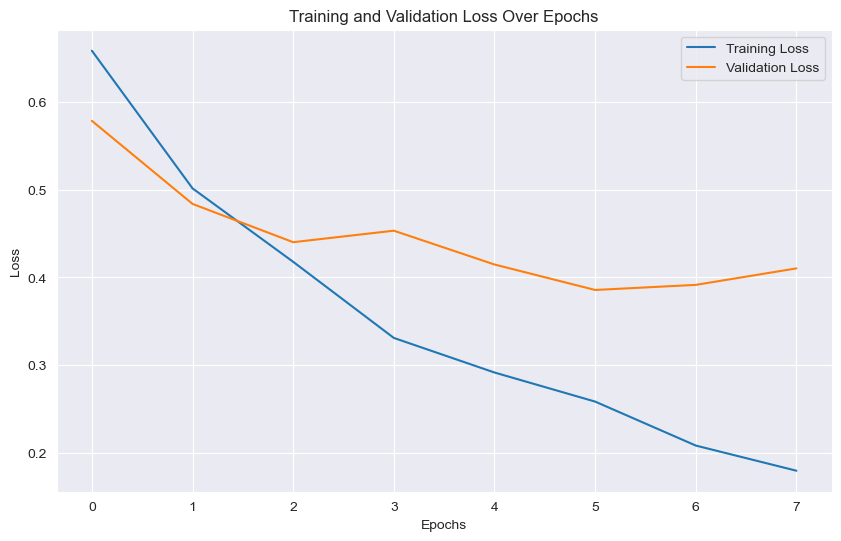

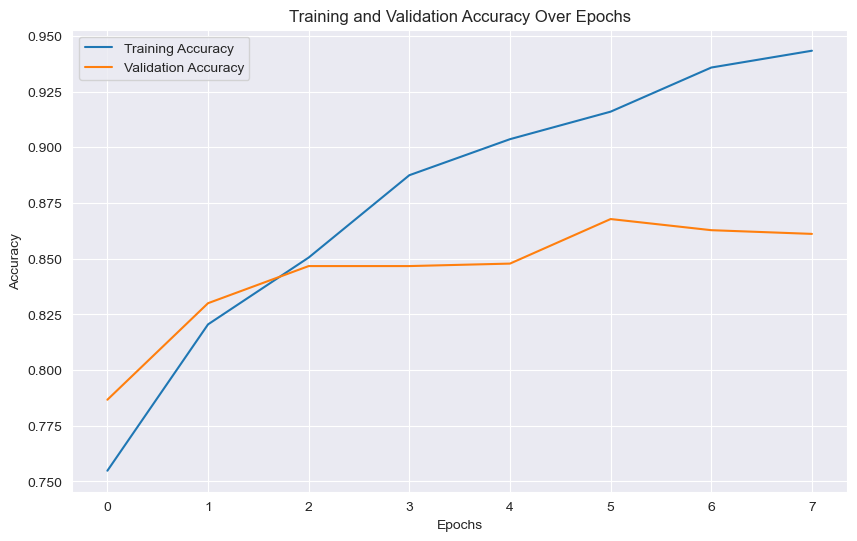

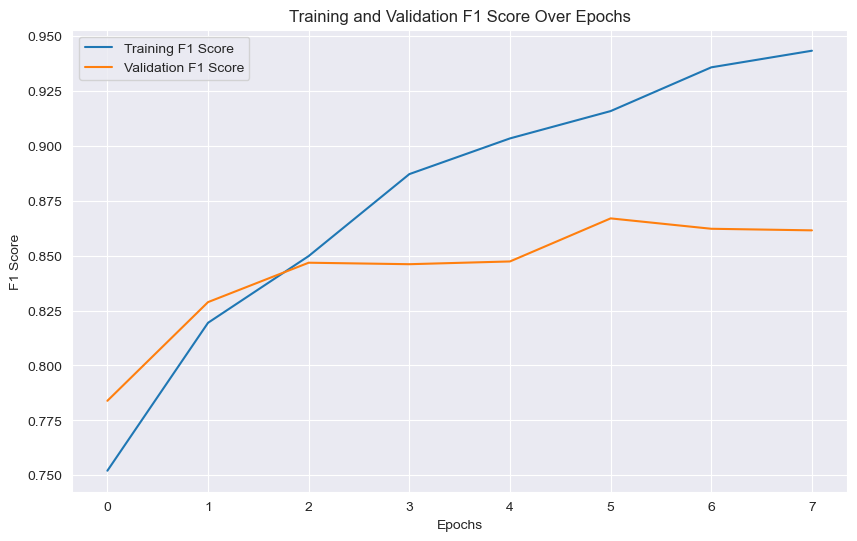

In [17]:
# Training loop with early stopping and performance tracking
# Set the number of epochs for training and early stopping parameters
num_epochs = 15
patience = 2  # Define patience for early stopping: number of epochs to wait if no improvement
best_val_loss = float('inf')  # Initialize best validation loss for early stopping comparison
trigger_times = 0  # Counter for how many times the validation loss has not improved


# Lists to store performance metrics for plotting later
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []
training_f1_scores = []
validation_f1_scores = []

# Training loop (Main)
for epoch in range(num_epochs):
        
    # Show Progress Bar (current epoch number)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    # Set model to training mode
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_predictions = []
        
    # Iterate over each batch in the training loader
    for images, descriptions, labels in tqdm(train_loader, desc="Training", leave=True):
        # Move tensors to the appropriate device (GPU or CPU)
        images, descriptions, labels = images.to(device), descriptions.to(device), labels.to(device)
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        outputs = model(images, descriptions)
        loss = criterion(outputs, labels) # Calculate the batch loss
        
        # Backward and optimize
        # compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        
        # Accumulate loss and calculate training accuracy for the epoch
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Collect labels and predictions for F1 Score
        all_train_labels.extend(labels.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())
    
    # Calculate training metrics:Compute training metrics for the current epoch
    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)
    
    training_accuracy = correct_train / total_train
    training_accuracies.append(training_accuracy)
    
    training_f1_score = f1_score(all_train_labels, all_train_predictions, average='weighted')
    training_f1_scores.append(training_f1_score)
    
    # Validation Phase:Switch model to evaluation mode for validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_predictions = []
    
    # No gradient updates during validation, to evaluate model performance    
    with torch.no_grad():
        for images, descriptions, labels in tqdm(val_loader, desc="Validation", leave=True):
            images, descriptions, labels = images.to(device), descriptions.to(device), labels.to(device)   
            outputs = model(images, descriptions)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy for validation data
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            # Calculate F1 Score evaluation: Collect labels and predictions for F1 Score
            all_val_labels.extend(labels.cpu().numpy())
            all_val_predictions.extend(predicted.cpu().numpy())
    
    # Calculate validation metrics
    validation_loss = val_loss / len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_accuracy = correct_val / total_val
    validation_accuracies.append(validation_accuracy)
    
    validation_f1_score = f1_score(all_val_labels, all_val_predictions, average='weighted')
    validation_f1_scores.append(validation_f1_score)
    
    # Print metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}, "
          f"Training Accuracy: {training_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}, "
          f"Training F1 Score: {training_f1_score:.4f}, Validation F1 Score: {validation_f1_score:.4f}")
    
    # Update learning rate
    scheduler.step()
    
    # Early Stopping check
    # if the validation loss has not improved-->Early Stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss # Update the best validation loss
        trigger_times = 0  # Reset trigger times
        # Save the best model
        torch.save(model.state_dict(), './Best-Model/best_model.pth')  
    else:
        # Increment the trigger count
        trigger_times += 1 
        print(f"Early stopping trigger times: {trigger_times}")

        # If the number of triggers equals the patience, stop the training        
        if trigger_times >= patience:
            print("Early stopping")
            break
            
# Final message to indicate training is complete
print("Training complete.")
print("######################################################")
print("Reports:")

# Plot performance metrics using the defined functions
plot_training_validation_loss(training_losses, validation_losses)
plot_training_validation_accuracy(training_accuracies, validation_accuracies)
plot_training_validation_f1_score(training_f1_scores, validation_f1_scores)


# Model Evaluation on Test Data
**This script sets the model to evaluation mode, disables gradient computation, and iterates over the test dataset to calculate accuracy and F1 scores. It also generates a confusion matrix and a classification report to analyze the model's performance across different classes, offering a concise overview of its predictive capabilities on unseen data.**

Test Accuracy: 82.25%
F1 Score (Weighted): 0.8209
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       695
           1       0.88      0.92      0.90       799
           2       0.79      0.87      0.83      1085
           3       0.87      0.80      0.83       852

    accuracy                           0.82      3431
   macro avg       0.82      0.81      0.82      3431
weighted avg       0.82      0.82      0.82      3431

Confusion Matrix:


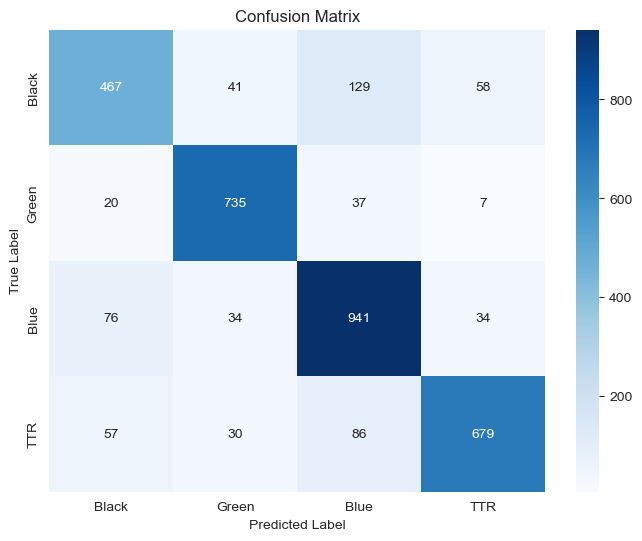

In [18]:
# Switch to evaluation mode
model.eval()

# Lists to store all true labels and predictions
all_labels = []
all_predictions = []

# No gradient computation for testing
# Disable gradient computation to reduce memory consumption and speed up computations
with torch.no_grad():
    correct = 0  # Counter for correct predictions
    total = 0  # Counter for total predictions

    # Iterate through the test dataset
    for images, descriptions, labels in test_loader:

        # Move tensors to the appropriate device (GPU or CPU)
        images, descriptions, labels = images.to(device), descriptions.to(device), labels.to(device)
        
        # Forward pass (Perform a forward pass to compute predictions)
        outputs = model(images, descriptions)
        _, predicted = torch.max(outputs, 1)
        
        # Calculate total and correct predictions for accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Collect all labels and predictions
        # Append labels and predictions to the lists for detailed analysis        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
    
    # Calculate the accuracy of the model on the test dataset
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    # Calculate the weighted F1 Score to take class imbalance into account    
    # using 'weighted' average to account for class imbalance
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score (Weighted): {f1:.4f}")

    
    # Print a detailed classification report
    class_report = classification_report(all_labels, all_predictions)
    print("Classification Report:")
    print(class_report)
        
    # Compute and display the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    #Visualize the confusion matrix for a clear presentation of model performance
    print("Confusion Matrix:")
    class_names = ['Black', 'Green', 'Blue', 'TTR']
    plot_confusion_matrix(conf_matrix, class_names)
    
    